## Задача 1
Сервис Яндекс.Еда привлекает новых клиентов в том числе с помощью скидок. При этом для повышения экономической эффективности необходимо отслеживать основные метрики по скидкам. Напишите код, который отвечает на следующие вопросы (можно использовать SQL или Python)
- Какая доля заказов с промокодами?
- Самый популярный (в метрике суммы скидки) промокод (название) и сумма скидки по нему?

Данные, которые есть (для простоты в формате .txt, несколько первых строк): <br>
<b>orders.txt</b> (если в заказе был промокод, то записываеся id промокода; если не было, то NULL) <br>
<b>promocodes.txt</b> (discount – сумма скидки в рублях)

In [1]:
######################################
## Test data for debugging purposes ##
######################################
# import string
# import random
# import numpy as np
# import pandas as pd
# random.seed(7)

# total_promocodes = 25
# total_orders = 10000

# promocodes = {
#     "promocode_id": list(map(str, range(0, total_promocodes))), 
#     "name": list(string.ascii_lowercase)[0:total_promocodes],
#     "discount": np.random.choice(np.linspace(10, 1000, num = 100), total_promocodes, replace = False)
# }

# orders = {
#     "order_id": list(range(0, total_orders)),
#     "promocode_id": np.random.choice(np.append(promocodes["promocode_id"], "NULL"), total_orders, replace = True)
# }

# df_promo = pd.DataFrame(data = promocodes)
# df_orders = pd.DataFrame(data = orders)

In [2]:
## Initialization of libraries & data importing
import numpy as np
import pandas as pd

df_orders = pd.read_csv("orders.txt", sep = ",")
df_promo = pd.read_csv("promocodes.txt", sep = ",")

In [3]:
## Creating general Data Frame with promo codes and orders information via left join
df_total = pd.merge(df_orders, df_promo, on = "promocode_id", how = "left")

## Cutting of NULL promocodes since we don't need them
null_share = df_total[df_total["promocode_id"] == "NULL"].agg("count")["order_id"]

print(
    "Share of orders with promo codes:", 
    str((1 - null_share/df_total.shape[0])*100) + "%"
)

## I believe there could be an optimization in counting ONLY NULL orders 
## But this would work only if total share of people using promo codes dominates over those who don't

Share of orders with promo codes: 96.07%


In [4]:
## Aggregating df_total with sum of discount and left-joining promo codes to acquire name of the most efficient code
discounts = pd.merge(
    df_total.groupby("promocode_id")["discount"].agg("sum"), 
    df_promo.drop("discount", axis = 1), 
    on = "promocode_id", how = "left"
)

print(
    "The most popular promo code (by total saves) is:",
    discounts.loc[discounts["discount"].idxmax()]["name"],
    "\nWith", int(discounts["discount"].max()), "total saves"
)

## There is probably an easier way to manipulate data since we DO have promo code names in df_total
## But, unfortunatelly pandas.DataFrame.agg documentations is showing only basic functionality
## Not the best example of using python/pandas data structures, but I tried ¯\_(ツ)_/¯

The most popular promo code (by total saves) is: p 
With 373100 total saves


## Задача 2
Яндекс.Еда осуществляет доставку еды из ресторанов. При этом у каждого ресторана есть зона, в рамках которой осуществляется доставка. Зона представляет собой полигон из координат. Пользователь в зависимости от своей координаты видит разное количество доступных ресторанов. Нам важно, чтобы у каждого пользователя было достаточное количество ресторанов для выбора. Задача заключается в том, чтобы по каждой координате пользователя посчитать доступное ему количество ресторанов. Можно использовать SQL или Python.

Данные, которые есть (для простоты в формате .txt, несколько первых строк): <br>
<b>user_coordinates.txt</b> (примерно 300 тыс строк, user_id – идентификатор пользователя) <br>
<b>place_zone_coordinates</b> (примерно 500 тыс строк, place_id – идентификатор ресторана, point_number – порядковый номер точки в зоне доставки ресторана) 

## Небольшая ремарка
Как аналитик, я сперва начал решать задачу, но как математик, задумался, что является полигоном и как его можно построить, и тут вот какое дело. 
По 4 точкам на плоскости, строго говоря, можно построить несколько **разных** фигур, причем множество может получиться, как выпуклым, так и невыпуклым. Если с выпуклыми многоугольниками всё понятно и, в общем случае, по 4 точкам можно построить одну и только одну фигуру, то в случае невыпуклого многоугольника, количество вариантов уже не равно единице. Из-за недостатка вводных данных по place_zone_coordinates данным я попытался решить задачу для фигуры, ограниченной n-точками, которые не упорядочены, чего у меня, в общем виде, сделать не получилось.

К сожалению, я не сразу заметил, что в 4 случайно брошенных точках на плоскости точках, количество невыпуклых многоугольников, которые можно построить > 1, поэтому искал решение через поиск наибольшей выпуклой оболочки в множестве точек, используя метод scipy.spatial.ConvexHull и количества пересечений прямых лучом, выходящим из точки. 



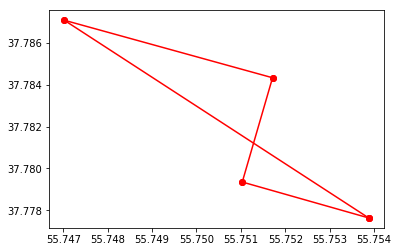

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
test_points = [[55.747022, 55.751713, 55.751031, 55.753878], [37.787073, 37.784328, 37.779351, 37.777638]]

for i in range(0, 4):
    plt.plot(test_points[0][i:i+2], test_points[1][i:i+2], 'ro-')
plt.plot([test_points[0][3], test_points[0][0]], [test_points[1][3], test_points[1][0]], 'ro-')
plt.show()

Так как нигде не указано, что количество точек многоугольника строго равно четырём, точки строго упорядочены и определяют некоторую фигуру, можно придумать такой пример из n-точек, который будет иметь "дыры" внутри области, а так как достаточно много всего было написано под решение СЛАУ и нахождение точки пересечения двух отрезков (если таковая существует), переписывать полностью задачу под вычисление количества оборотов вокруг точки времени не осталось :(

Поэтому, сразу оговариваю, что следующий код работает только для **строго упорядоченных** данных, в которых фигуры ограничены 4 точками, и отрезки, ограничивающие фигуры, соединяются по порядковым номерам (замыкаясь к начальной точке в самом конце). Реализован алгоритм количества пересечений луча в случайном направлении.

In [6]:
######################################
## Test data for debugging purposes ##
######################################
# import random
# random.seed(7)

# def create_zone(point, total):
#     zone = pd.DataFrame({
#         "place_id": list(range(0, total)),
#         "loc_lat": np.random.normal(0, 1, total),
#         "loc_lon": np.random.normal(0, 1, total),
#         "point_number": point
#     })
#     return(zone)

# total_users = 100
# total_zones = 100

# df_users = pd.DataFrame({
#     "user_id": list(range(0, total_users)), 
#     "loc_lat": np.random.normal(0, 1, total_users),
#     "loc_lon": np.random.normal(0, 1, total_users)
# })

# df_zones = pd.concat([
#     create_zone(0, total_zones),
#     create_zone(1, total_zones),
#     create_zone(2, total_zones),
#     create_zone(3, total_zones)
# ])

In [7]:
import matplotlib.pyplot as plt

## This functions finds an intersection of the lines 
## The idea of the method is to find an intersection of lines (if one exists)
## by solving system of linear equations via Cramer's rule 
def lines_intersection(points):
    A = np.array([points[0][0], points[0][1]])
    B = np.array([points[1][0], points[1][1]])
    C = np.array([points[2][0], points[2][1]])
    D = np.array([points[3][0], points[3][1]])
    
    def line_params(A, B):
        return(
            np.array([
                A[1] - B[1],
                B[0] - A[0],
                - A[0]*B[1] + B[0]*A[1]
            ])
        )
    
    ## Getting the parameters of the lines equations
    equation_1 = line_params(A, B)
    equation_2 = line_params(C, D)
    
    D = np.linalg.det(np.array([
        [equation_1[0], equation_1[1]],
        [equation_2[0], equation_2[1]]
    ]))
    
    ## If matrix is singular than two lines are parallel and thus having no intersection
    if D == 0:
        print("Determinant is equal 0, lines are parallel")
        return(False)
    
    D_x = np.linalg.det(np.array([
        [equation_1[2], equation_1[1]],
        [equation_2[2], equation_2[1]]
    ]))
    D_y = np.linalg.det(np.array([
        [equation_1[0], equation_1[2]],
        [equation_2[0], equation_2[2]]
    ]))
    
    intersection_point = np.array([D_x/D, D_y/D])
    
    ## Checking if the intersection point actually lies between two given points 
    ## If not, the intersection is further than we need to 
    if (A[0] <= intersection_point[0] <= B[0]) & (A[1] <= intersection_point[1] <= B[1]):
        # print("Success!")
        return(True)
    else: 
        # print("There is no intersection")
        return(False)
    
## Printing plot of area and user location (without lines)
def print_plot(zone, user_line):
    for index, row in zone.iterrows():
        plt.plot(row["loc_lat"], row["loc_lon"], "ro")
    plt.plot(user_line[0][0], user_line[0][1], ".")
    plt.show()
    return()

## Checking if user is in zone
def in_zone(zone, user_line):
    points = []
    for index, row in zone.iterrows():
        points.append([row["loc_lat"], row["loc_lon"]])
    points.append(points[0])
    
    total_intersections = 0
    for i in range(0, len(points)-1):
        system = [points[i], points[i+1], user_line[0], user_line[1]]
        total_intersections += lines_intersection(system)
    if (total_intersections % 2) == 0:
        return(False)
    else:
        return(True)

In [8]:
#df_users = pd.read_csv("user_coordinates.txt", sep = ",")
#df_zones = pd.read_csv("place_zone_coordinates.txt", sep = ",")

#### Main work
df_zones.sort_values(by = ["place_id", "point_number"])
faraway = [9999, 9999]

total_restaurants = []
for index, user in df_users.iterrows():
    user_line = [[user["loc_lat"], user["loc_lon"]], faraway]
    
    ## Cycle by zones 
    user_intersections = 0
    for i in range(0, 100):
        zone = df_zones[df_zones["place_id"] == i]
        zone_result = in_zone(zone, user_line)
        user_intersections += zone_result
    
    total_restaurants.append(user_intersections)

In [9]:
df_users["number_of_places_available"] = total_restaurants
df_users.drop(["loc_lat", "loc_lon"], axis = 1).head()

,user_id,number_of_places_available
0,0,27
1,1,24
2,2,38
3,3,12
4,4,30


## Задача 3
Мы в Яндекс.Еде любим поиграть в покер и настольные игры. Поэтому нам важно, чтобы будущие коллеги были сильны в математической статистике и теории вероятностей (так интереснее играть))) Если серьезно, то в большинстве аналитических задач у нас возникает необходимость применять математический аппарат в том или ином виде. Проще всего его проверить через учебные игровые задачи, чтобы не погружать в сложный контекст бизнеса.
Вы подбрасываете кубик (6 граней), после чего у вас есть две возможности:
1. Взять себе сумму \\$, равную выпавшему на кубике числу (выпало 3 – получаете 3\\$)
2. Отклонить результат первого броска и подбросить кубик второй раз. После чего уже взять себе столько \\$, сколько выпало во второй раз (второй бросок отклонять уже нельзя)
Какую стратегию нужно выбрать, чтобы максимизировать ожидаемую прибыль (при каких значениях первого броска нужно перебрасывать?)<br> 
Почему эта стратегия максимизирует прибыль? <br>
Чему равна ожидаемая прибыль при этой стратегии (**математическое ожидание**)?


## Решение
Перекидывать стоит результаты первого броска кубика, в случае, если математическое ожидание броска кубика больше, чем полученный текущий результат.
Математическое ожидание броска кубика = 3.5

То есть, мы перекидываем кубик, только если выпали значения 1-3, таким образом математическое ожидание такой случайной величины = 4.25